In [103]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.io import netcdf
from shapely.geometry import Point

## Geographically visualise datapoints

In [5]:
# read data from netcdf files

file2read_2015 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2015.nc','r')
file2read_2016 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2016.nc','r')
file2read_2017 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2017.nc','r')
file2read_2018 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2018.nc','r')
file2read_2019 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2019.nc','r')

temp_2015 = file2read_2015.variables["dis24"]
temp_2016 = file2read_2016.variables["dis24"]
temp_2017 = file2read_2017.variables["dis24"]
temp_2018 = file2read_2018.variables["dis24"]
temp_2019 = file2read_2019.variables["dis24"]

/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_64108/2496670625.py:3: DeprecationWarning: `scipy.io.netcdf.NetCDFFile` is deprecated along with the `scipy.io.netcdf` namespace. `scipy.io.netcdf.NetCDFFile` will be removed in SciPy 1.14.0, and the `scipy.io.netcdf` namespace will be removed in SciPy 2.0.0.
  file2read_2015 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2015.nc','r')
/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_64108/2496670625.py:4: DeprecationWarning: `scipy.io.netcdf.NetCDFFile` is deprecated along with the `scipy.io.netcdf` namespace. `scipy.io.netcdf.NetCDFFile` will be removed in SciPy 1.14.0, and the `scipy.io.netcdf` namespace will be removed in SciPy 2.0.0.
  file2read_2016 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2016.nc','r')
/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_64108/2496670625.py:5: DeprecationWarning: `scipy.io.netcdf.NetCDFFile` is deprecated along with the `scipy.io.netcdf` namespace.

In [6]:
# select longitude and latitude
lon_values = file2read_2015.variables["lon"][:]
lat_values = file2read_2015.variables["lat"][:]

In [7]:
# preprocessing

data_2015 = temp_2015[:]*1
data_2016 = temp_2016[:]*1
data_2017 = temp_2017[:]*1
data_2018 = temp_2018[:]*1
data_2019 = temp_2019[:]*1

data_2015[data_2015==1e20] = np.nan
data_2016[data_2016==1e20] = np.nan
data_2017[data_2017==1e20] = np.nan
data_2018[data_2018==1e20] = np.nan
data_2019[data_2019==1e20] = np.nan

## just 2015

In [74]:
import xarray as xr

# Open the netCDF file using xarray
data_2015 = xr.open_dataset('../data/yearly_discharge/discharge_2015.nc')

# Convert the xarray Dataset to a pandas DataFrame
df = data_2015.to_dataframe()

# Reset the index to flatten the multi-index DataFrame
df.reset_index(inplace=True)

# drop missing
df.replace(1e20, np.nan, inplace=True)
df.dropna(inplace=True)

to_plot = df[df['time']=='2015-01-01']
to_plot

,time,lon,lat,dis24
0,2015-01-01,60.05,37.95,0.000119
1,2015-01-01,60.05,37.85,0.001098
2,2015-01-01,60.05,37.75,0.000071
3,2015-01-01,60.05,37.65,0.000046
4,2015-01-01,60.05,37.55,0.000217
...,...,...,...,...
123995,2015-01-01,99.95,7.45,9.600554
123996,2015-01-01,99.95,7.35,4.929910
123997,2015-01-01,99.95,7.25,3.744672
123998,2015-01-01,99.95,7.15,7.509447


#### map

In [76]:
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(to_plot['lon'], to_plot['lat'])]

geo_df = gpd.GeoDataFrame(to_plot, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,time,lon,lat,dis24,geometry
0,2015-01-01,60.05,37.95,0.000119,POINT (60.05000 37.95000)
1,2015-01-01,60.05,37.85,0.001098,POINT (60.05000 37.85000)
2,2015-01-01,60.05,37.75,0.000071,POINT (60.05000 37.75000)
3,2015-01-01,60.05,37.65,0.000046,POINT (60.05000 37.65000)
4,2015-01-01,60.05,37.55,0.000217,POINT (60.05000 37.55000)


<Axes: >

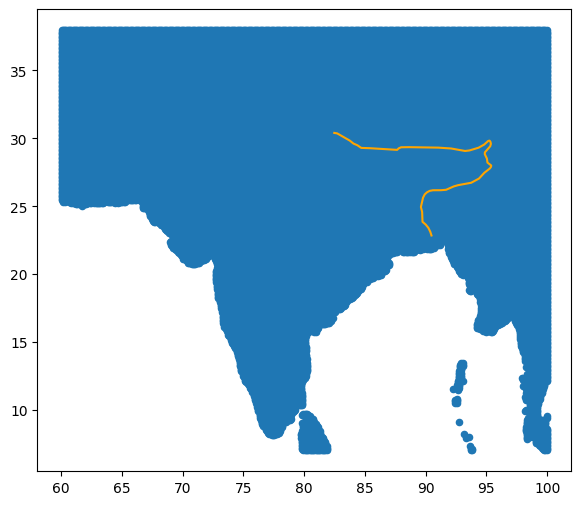

In [79]:
fig, ax = plt.subplots(figsize=(13,6))

river_map = gpd.read_file('../data/centerlines_data/ne_110m_rivers_lake_centerlines.shp')
brahmaputra = river_map[river_map['name'] == 'Brahmaputra']

geo_df.plot(ax=ax, markersize=20, marker='o')
brahmaputra.plot(ax=ax, color='orange')

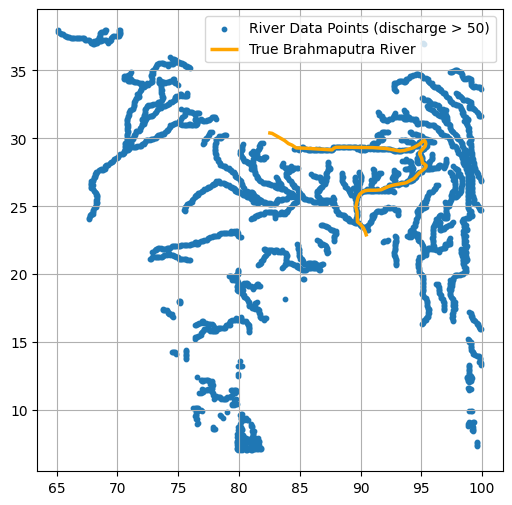

In [150]:
fig, ax = plt.subplots(figsize=(13,6))

geo_df[geo_df['dis24'] > 50].plot(ax=ax, markersize=10, marker='o', label='River Data Points (discharge > 50)')
brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River')
plt.legend()
plt.grid(True)

add other rivers to the plot in another colour 

axes, labels 

other features? 

In [127]:
threshold = 15  # Define threshold for "close to zero" (using above plot)
mask = geo_df['dis24'].abs() > threshold
filtered_df = geo_df[mask]

In [128]:
# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return point1.distance(point2)

In [138]:
# Convert river to a list of individual points (lon, lat)
river_linestring = brahmaputra.iloc[0]['geometry']
river_points = list(river_linestring.coords)

# Create a list to store the closest points
closest_points = []

# Iterate over each true coordinate in river_points
for true_coord in river_points:
    true_point = Point(true_coord)
    min_distance = float('inf')  # Initialise with infinity
    closest_point = None
    
    # Iterate over each row in filtered_df
    for index, row in filtered_df.iterrows():
        # Check if the 'geometry' column contains a valid geometry object
        if not pd.isna(row['geometry']):
            # Calculate distance between true_point and row's geometry
            distance = calculate_distance(row['geometry'], true_point)
            # Check if this distance is smaller than the current minimum
            if distance < min_distance:
                min_distance = distance
                closest_point = index  # Store the index of the closest row
    
    # Append the index of the closest point to the list
    closest_points.append(closest_point)

# Filter out only the rows with closest points
filtered_df_closest = filtered_df.loc[closest_points]

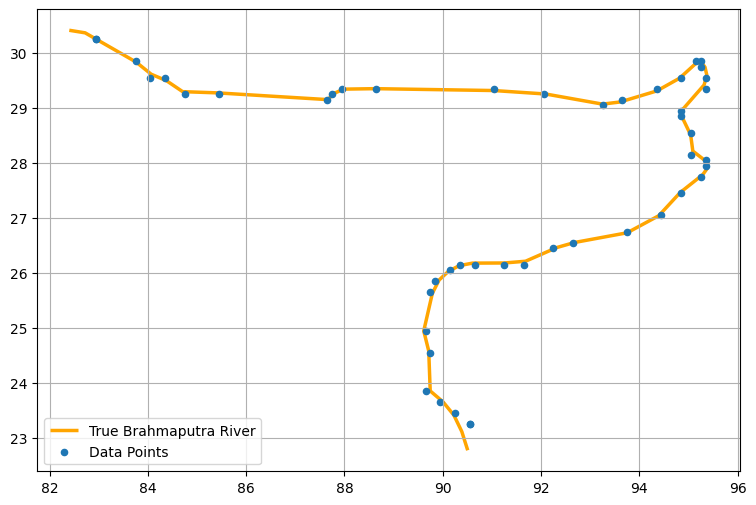

In [154]:
fig, ax = plt.subplots(figsize=(13,6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)
filtered_df_closest.plot(ax=ax, markersize=20, marker='o', label='Data Points', zorder=1)

plt.legend()
plt.grid(True)

In [145]:
# not saved to data folder, which is in gitignore
filtered_df_closest.to_csv('../river_data.csv', index=False)